# main

Now I'm studying the exact same setup as `src/30`, but in two dimensions.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import copy
import auxiliary6 as aux

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

%reload_ext autoreload
%autoreload 2

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
src_n = 31
dataDir = f'../data.lbm/{src_n}/'
# dataDir = f'../src/{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dataDir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

12

# Fluid

In [4]:
# id += 1
id = -1
fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y"]).sort_index()

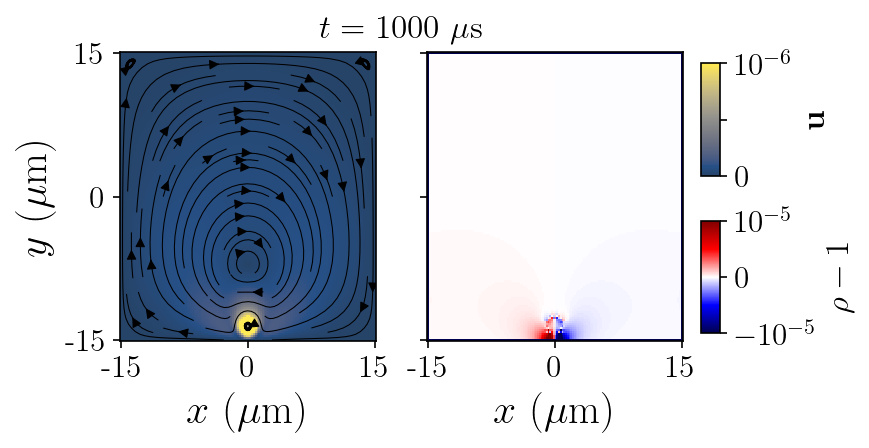

In [5]:
title = f"$t = {fluidDf.time.values[0]:.0f}$"+" $\\mu \\mathrm{s}$"
fig, axes = aux.fluidOverview(fluidDf, title)
# plt.savefig("figure1.png", format="png", transparent=True, dpi=1000, bbox_inches="tight")
plt.show()

# Particle

The box coordinates are $x,y \in [-15, 15]$.

The initial position of the particle is $\mathbf{r}_0 = -13.5~\mathbf{\hat{y}}$, and the angular velocity is ${\omega} = + 1 ~ {\mathrm{rad}}/{\mathrm{s}}$, i.e. It is above to the $x$ axis, and it rotates such that it should swim towards $-\mathbf{\hat{x}}$. As it happens, it swims towards $\mathbf{\hat{x}}$. I currently suspect this is due to dimensionality, somehow.

In [6]:
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")
particleDf.time.array[-1]

np.float64(999.9310344828524)

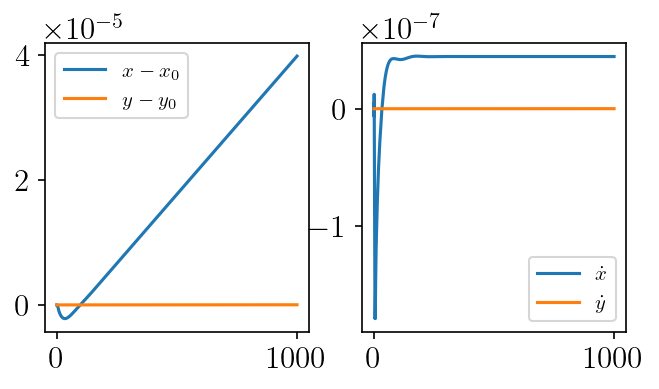

In [7]:
fig, axes = aux.particleTrjOverview(particleDf)
plt.show()

# Stability analysis

In an effort to verify a stable equilibrium state was achieved, the mean fluid speed is studied as a function of time.

In [8]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

In [9]:
try:
    avgFluidSpeed 
except NameError:
    avgFluidSpeed = []
    
try:
    time 
except NameError:
    time = []

for tick in ticks[len(time)::]:
    auxDf = pd.read_csv(dataDir + f"fluidTrj_{tick}.csv")
    avgFluidSpeed.append(avgSpeed(auxDf))
    time.append(auxDf.time.values[0])
    print(f'\r{tick}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

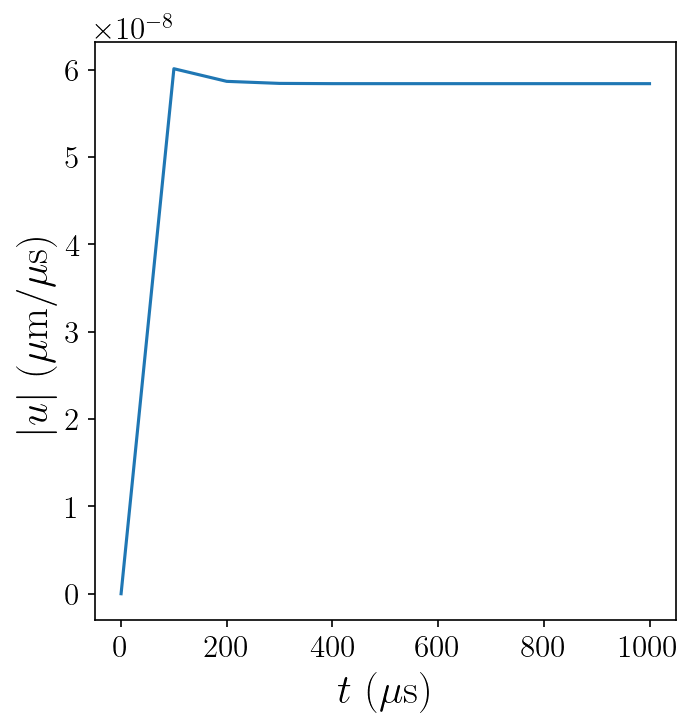

In [10]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, avgFluidSpeed)
ax.set_xlabel("$t ~ (\\mu \\mathrm{s})$")
ax.set_ylabel("$|u| ~ (\\mu \\mathrm{m} / \\mu \\mathrm{s})$")

plt.show()

# Animation

In [ ]:
# necessary directories are created
outputDir = f"frames.{src_n}"
os.system(f'mkdir -p anims')
os.system(f'mkdir {outputDir}')

# the data is read and frames are saved
for tickId in np.arange(len(ticks)):
    fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[tickId]}.csv").set_index(["id_x","id_y"]).sort_index()
    title = f"$t = {fluidDf.time.values[0]:.0f}$"+" $\\mu \\mathrm{s}$"
    fig, axes = aux.fluidOverview(fluidDf, title)

    plt.savefig(f"{outputDir}/{tickId}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close()
    print(f'\r{tickId}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

# ffmpeg is used to create the animation
mkAnimSh = f'ffmpeg -framerate 15 -i {outputDir}/%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -loglevel quiet anims/src_{src_n}.mp4'
os.system(mkAnimSh)

# the directory with the frames is erased
os.system(f'rm -r {outputDir}')